In [33]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from thermography_dataset import ThermDataset
from sklearn.preprocessing import StandardScaler
%matplotlib inline

## Parameters 

In [34]:
args = {'lr':0.01,
        'batch_size':32,
        'epochs':100,
        'noise':0.001,
        'train_size':0.8,
        }

# Prepare Data

In [35]:
dataset = ThermDataset(fp='combined_data.xlsx', direction=0, noise_scale=args['noise'], tandem=1)

In [36]:
train_size = int(args['train_size'] * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

In [37]:
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=args['batch_size'])
test_loader = DataLoader(test_dataset, shuffle=True, batch_size=args['batch_size'])

# Design Model 
(input size, output size, forward pass)

In [38]:
# spec in temp out
class SubNN(nn.Module):
    def __init__(self, spec_size, temp_size):
        super(SubNN, self).__init__()
        self.lin1 = nn.Linear(spec_size, 45)
        self.lin2 = nn.Linear(45, 15)
        self.lin3 = nn.Linear(15, 5)
        self.lin_fin = nn.Linear(5, temp_size)


    def forward(self, x):
        temp_pred = F.leaky_relu(self.lin1(x))
        temp_pred = F.leaky_relu(self.lin2(temp_pred))
        temp_pred = F.leaky_relu(self.lin3(temp_pred))
        temp_pred = self.lin_fin(temp_pred)
        return temp_pred

In [39]:
# spec in spec out
class MainNN(nn.Module):
    def __init__(self, temp_size, spec_size):
        super(MainNN, self).__init__()
        self.subnet = SubNN(spec_size=spec_size, temp_size=temp_size) # spec in temp out
        self.lin1 = nn.Linear(temp_size, 5) # temp in spec out
        self.lin2 = nn.Linear(5, 15)
        self.lin3 = nn.Linear(15, 45)
        self.lin_fin = nn.Linear(45, spec_size)

    def forward(self, x):
        temp_pred = self.subnet(x)

        spec_pred = F.leaky_relu(self.lin1(temp_pred))
        spec_pred = F.leaky_relu(self.lin2(spec_pred))
        spec_pred = F.leaky_relu(self.lin3(spec_pred))
        spec_pred = self.lin_fin(spec_pred)

        return spec_pred, temp_pred

In [40]:
n_samples = len(train_dataset)
_, temp_size = dataset.x.shape
_, spec_size = dataset.y.shape

model = MainNN(temp_size=temp_size, spec_size=spec_size)

# Construct Loss and Optimizer

In [41]:
learning_rate = args['lr']
criterion = nn.L1Loss()
optimizer = torch.optim.RAdam(model.parameters(), lr=learning_rate)

# Training Loop

In [42]:
num_epochs = args['epochs']
loss_list = []
temp_loss_list = []
spec_loss_list = []
best_loss = np.inf
best_epoch = 0

for epoch in range(num_epochs):
    for temp_batch, spec_batch in train_loader:        
        # empty gradients
        optimizer.zero_grad()

        # forward pass and loss
        spec_pred, _ = model(spec_batch)
        temp_pred = model.subnet(spec_batch)

        # get loss
        spec_loss = criterion(spec_pred, spec_batch)
        temp_loss = criterion(temp_pred, temp_batch)
        total_loss = spec_loss + temp_loss

        # backward pass
        total_loss.backward()

        # update
        optimizer.step()

        

    loss_list.append(temp_loss.item())
    spec_loss_list.append(spec_loss.item())
    temp_loss_list.append(temp_loss.item())

    if temp_loss < best_loss:
        best_loss = temp_loss
        best_epoch = epoch+1

    if (epoch+1) % int(num_epochs/10) == 0:
        print(f'epoch: {epoch+1}, spectrum loss = {spec_loss:.6f}, temperature loss = {temp_loss:.6f}')

print(f'\nbest temperature loss: {best_loss:.3f} in epoch: {best_epoch}')

epoch: 10, spectrum loss = 0.083445, temperature loss = 97.970879
epoch: 20, spectrum loss = 0.611310, temperature loss = 11.193032
epoch: 30, spectrum loss = 0.634562, temperature loss = 14.135163
epoch: 40, spectrum loss = 0.623316, temperature loss = 11.256921
epoch: 50, spectrum loss = 0.612584, temperature loss = 11.116908
epoch: 60, spectrum loss = 0.136749, temperature loss = 9.319469
epoch: 70, spectrum loss = 0.083001, temperature loss = 10.320744
epoch: 80, spectrum loss = 0.063712, temperature loss = 10.315763
epoch: 90, spectrum loss = 0.159377, temperature loss = 11.263709
epoch: 100, spectrum loss = 0.098965, temperature loss = 12.895347

best temperature loss: 8.811 in epoch: 82


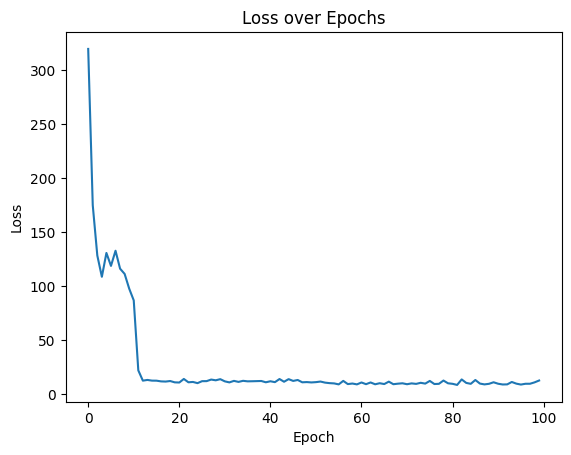

In [43]:
plt.plot(loss_list, label='total loss')
#plt.plot(spec_loss_list[20:], label='spectrum loss')
#plt.plot(temp_loss_list[10:50], label='temperature loss')

plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

# Testing

In [44]:
import matplotlib.pyplot as plt

def plot_actual_vs_pred(pred, actual, index, prediction):
    actual_np = actual[index]
    pred_np = pred[index]

    if prediction == 'spec':
        plt.title("Radiation Spectrum")
        plt.xlabel("Wavlength")
        plt.ylabel("Intensity")
        pred_np = pred_np * (10**-12)
        actual_np = actual_np * (10**-12)
        wavelengths = dataset.wavelengths
        plt.plot(wavelengths, actual_np, label='actual')
        plt.plot(wavelengths, pred_np, 'r+', label='predicted')
    else:
        plt.title("Temperature Distribution")
        plt.xlabel("Layer")
        plt.ylabel("Temperature (K)")
        x = np.arange(1, 12, 1)
        plt.plot(x, actual_np, label='actual')
        plt.plot(x, pred_np, 'r+', label='predicted')
        plt.xticks(np.arange(min(x), max(x)+1, 1.0))

    

    plt.legend()
    plt.show()

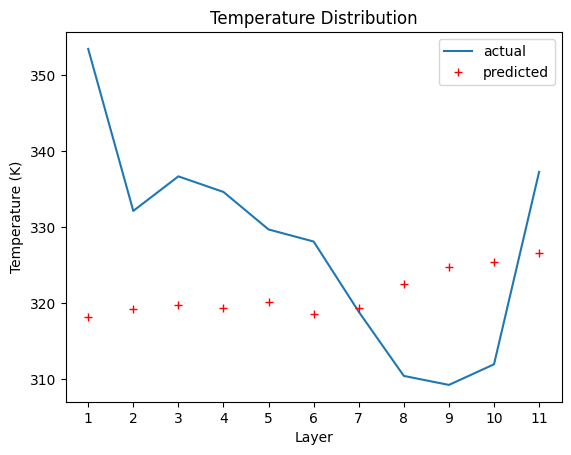

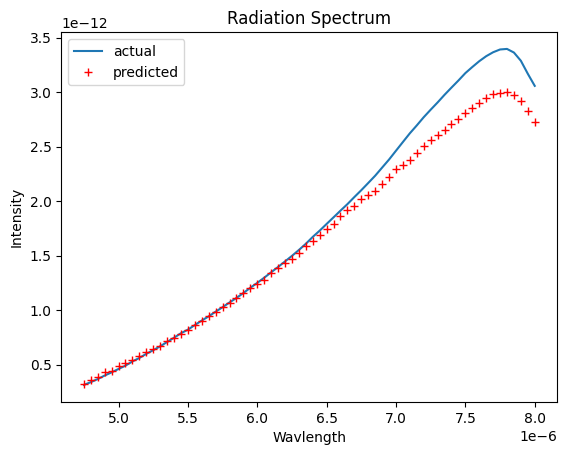

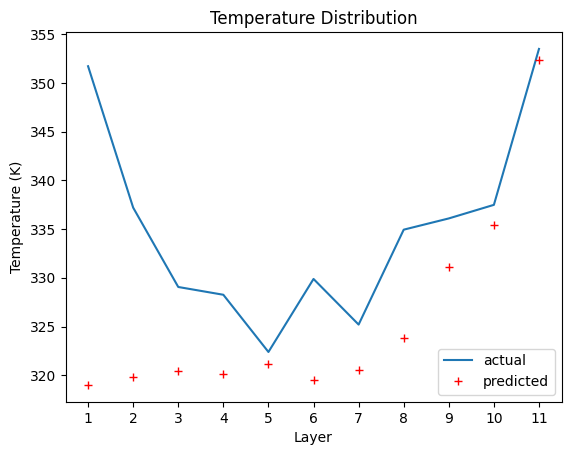

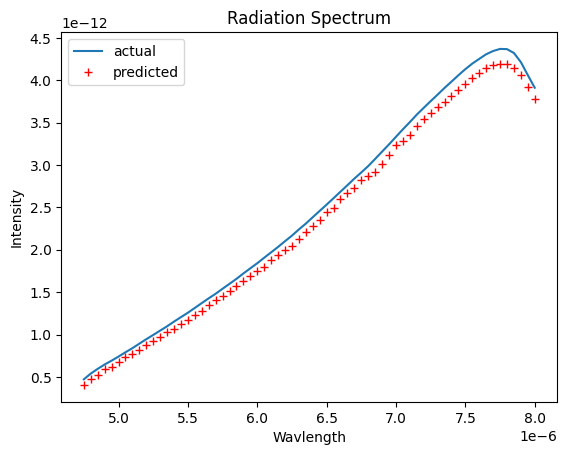

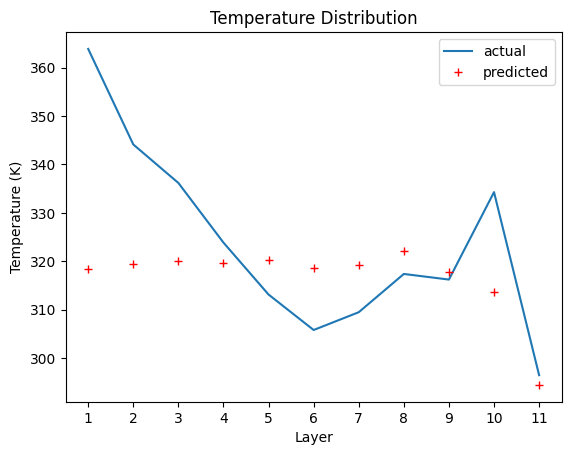

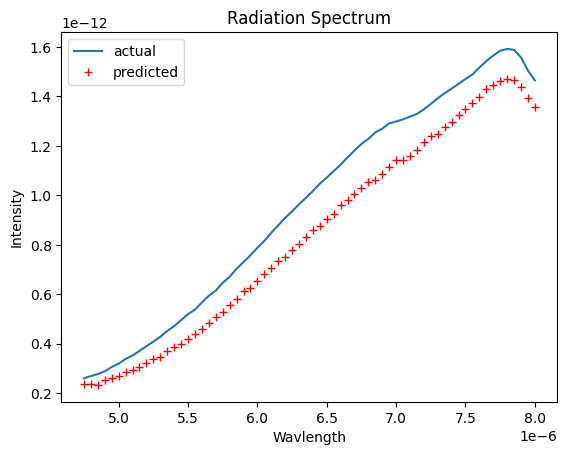

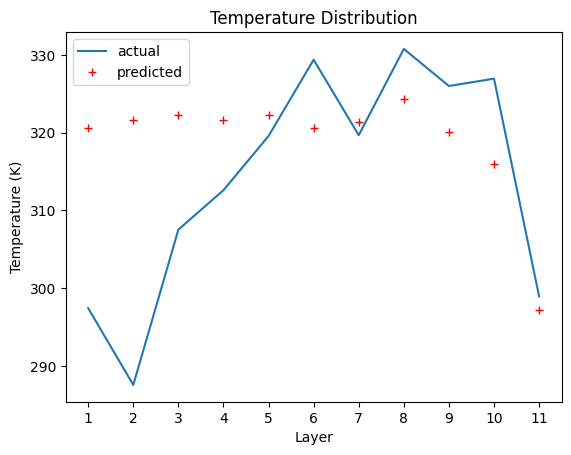

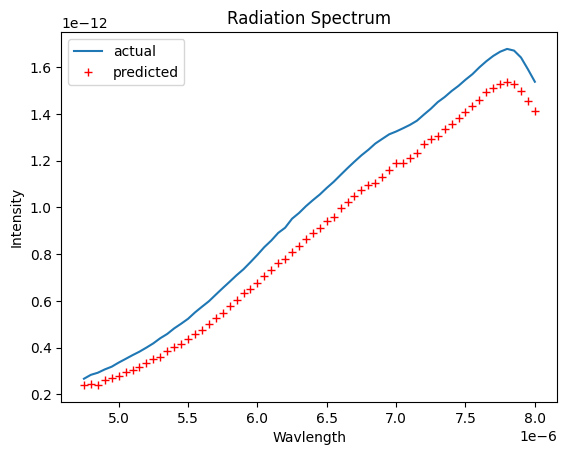

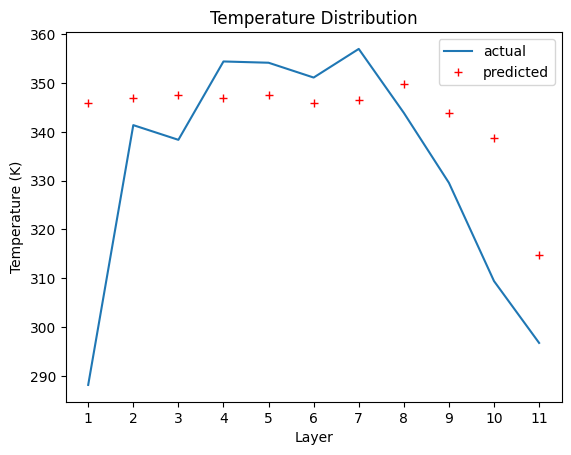

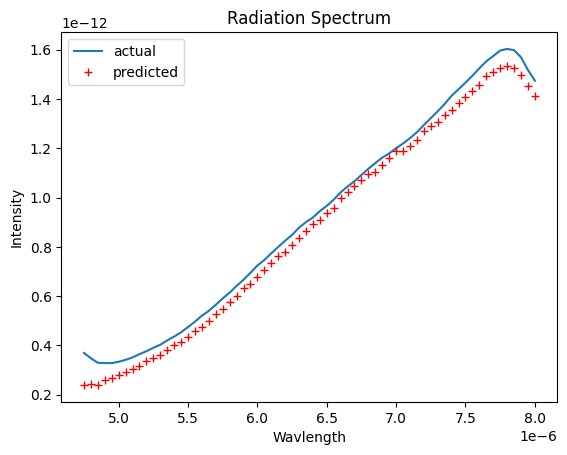

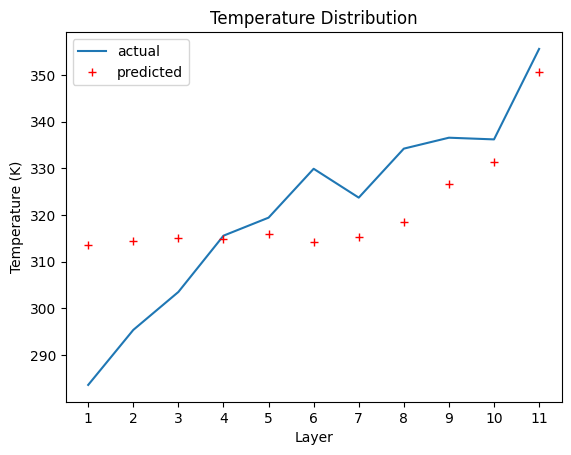

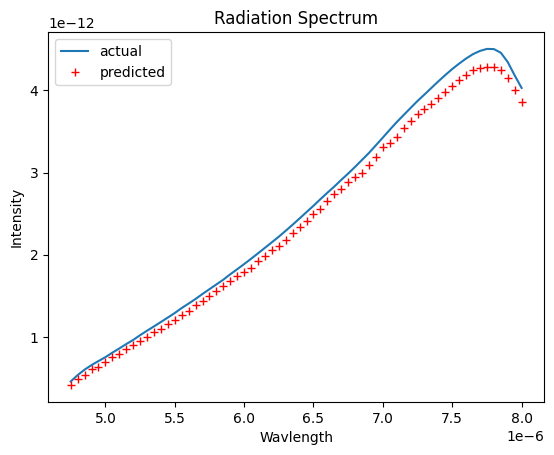

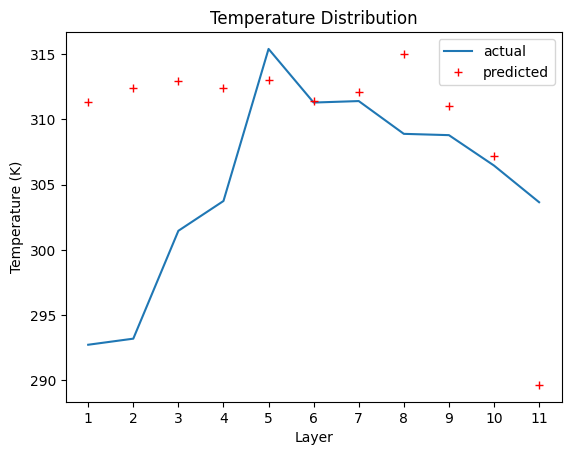

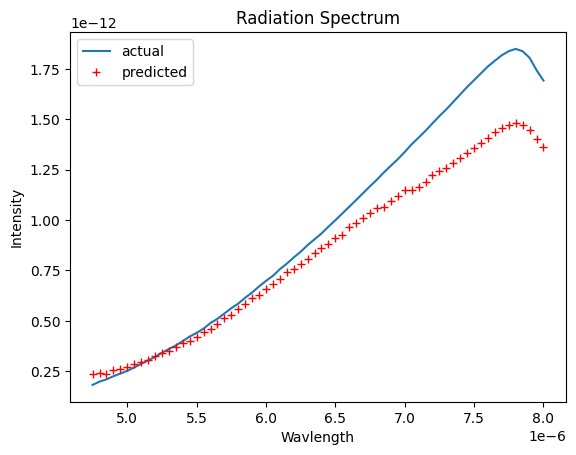

average temperature loss: 9.830
average spectrum loss: 0.120528


In [45]:
total_temp_loss = 0
total_spec_loss = 0
n_samples = 0
total_batches = len(test_loader)
current_batch = 0


with torch.no_grad():
    for temp_batch, spec_batch in test_loader:
        spec_pred, temp_pred = model(spec_batch)
        
        temp_loss = criterion(temp_pred, temp_batch)
        total_temp_loss += temp_loss.item() * len(temp_batch)

        spec_loss = criterion(spec_pred, spec_batch)
        total_spec_loss += spec_loss.item() * len(spec_batch)

        n_samples += len(temp_batch)
        current_batch += 1

        if current_batch % int(total_batches/5) == 0:
            plot_actual_vs_pred(temp_pred.numpy(), temp_batch.numpy(), 0, prediction='temp') 
            plot_actual_vs_pred(spec_pred.numpy(), spec_batch.numpy(), 0, prediction='spec')

average_temp_loss = total_temp_loss/n_samples
average_spec_loss = total_spec_loss/n_samples
print(f"average temperature loss: {average_temp_loss:.3f}\naverage spectrum loss: {average_spec_loss:.6f}")